# Extreme Values Analysis

In [1]:
import numpy as np
import pandas as pd
from Snoopy import Statistics as st
from Snoopy.TimeDomain import TEST_DIR
from matplotlib import pyplot as plt
from datetime import timedelta

During this tutorial, we'll learn how to perform Extreme-Value-Analysis thanks to Snoopy. We'll study an Hs series of duration 24 years.

In [2]:
data = pd.read_csv( f"{TEST_DIR}/hs.csv" , parse_dates = True, index_col = 0 ).hs
duration = (data.index[-1] - data.index[0] ).total_seconds() / (365.24*24*3600)

## Declustering
To remove correlations between maxima events close to one another in time, it is possible to decluster the data using a rolling window.
Here is the declustering function using maximum on a rolling window: 

In [3]:
data_decluster = st.rolling_declustering( data, window = pd.offsets.Day(10)  )

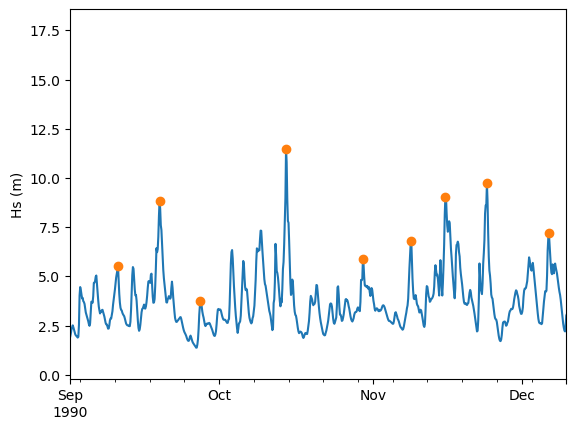

In [4]:
fig, ax = plt.subplots()
data.plot(ax=ax)
data_decluster.plot(ax=ax,  marker ="o" , linestyle = "");
ax.set(xlim = [data.index[0] , data.index[0]  + pd.offsets.Day(100) ], ylabel = "Hs (m)");

Note that it is also possible to parameterize the moving window with a size expressed in number of elements. Thus, if we use window_int = ..., we have : 

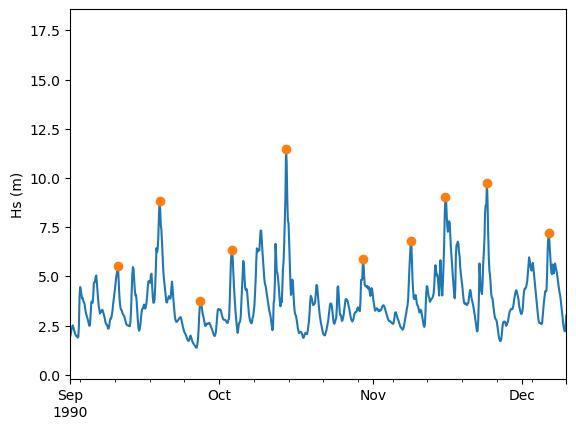

In [5]:
data_decluster_int = st.rolling_declustering( data, window_int = 80 )
fig, ax = plt.subplots()
data.plot(ax=ax)
data_decluster_int.plot(ax=ax,  marker ="o" , linestyle = "");
ax.set(xlim = [data.index[0] , data.index[0]  + pd.offsets.Day(100) ], ylabel = "Hs (m)");

## Peak Over Threshold
In a "Peak-over-threshold" analysis, only the peaks of the signal above a certain threshold are kept. If the observations are not independent, it may be necessary to decluster the signal as shown above. Here is an example of a P-o-T analysis.

In [6]:
pot = st.POT_GPD( data_decluster, duration=duration, threshold = np.quantile(data_decluster, 0.95) )

Here is a command to **display the peaks over the threshold** retained by our PoT method.

<AxesSubplot:xlabel='Time'>

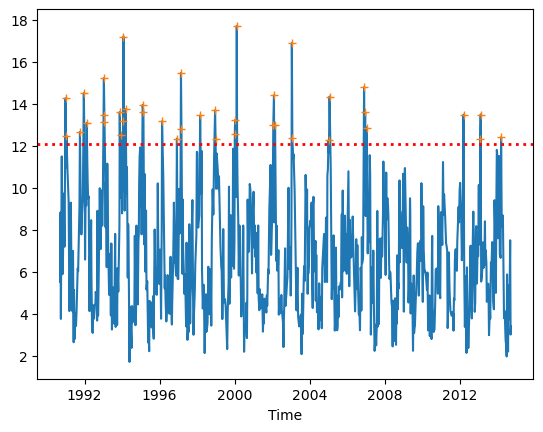

In [7]:
pot.plot_threshold()

Our goal is often to **obtain return levels for given return periods**, with related confidence intervales. Here is how to do it.

<AxesSubplot:xlabel='Return period'>

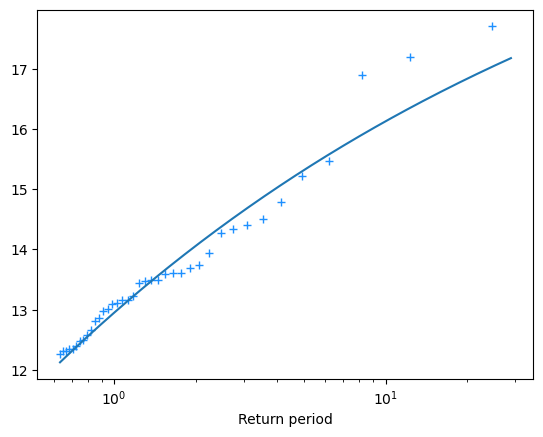

In [8]:
fig, ax = plt.subplots()
pot.plot_rp_data(ax=ax, color = "dodgerblue")
pot.plot_rp_fit(ax=ax)

The class also provides the calculation (and display of **confidence intervals**). The method of calculation CI, the confidence-level, the return period range and display parameters can be tuned !

<AxesSubplot:xlabel='Return period'>

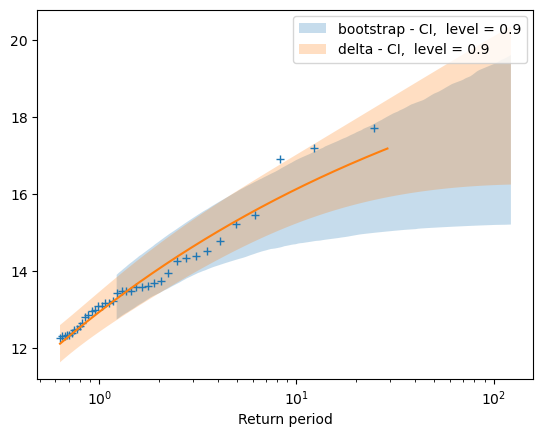

In [9]:
fig, ax = plt.subplots()
pot.plot_rp_data(ax=ax)
pot.plot_rp_fit(ax=ax)
pot.plot_rp_ci(ax=ax, ci_level=0.9)
pot.plot_rp_ci(ax=ax, ci_level = 0.9, ci_type="delta")

If we want to obtain the return level associated to a given return period, we can calculate it empirically or through a fitted distribution.

In [10]:
pot.rp_to_x_empirical( 10 )
pot.rp_to_x( 10 )

16.129073924612225

It is also possible to compute the **confidence interval for a return period period** (at a given confidence level) , as well as the **relative uncertainty**.

In [11]:
pot.rp_to_xci( rp = 1 )
pot.rp_to_rel_ci( 10 )

0.07745324187764767

Note that it is possible to do both the declustering and the POT at once (meaning using a TimeSeries in entry) : 

In [12]:
pot_ts = st.POT_GPD.FromTimeSeries( data, duration=duration, threshold_q = 0.9 , window = pd.offsets.Day(10) )

## Block-Maxima Approch
In a block-Maxima approach, the signal is cut into pieces of the same length, and the maximum is extracted on each of the constructed blocks. The block-maxima provides a global decorrelation of the signal. But if a sequence of extreme events is located at the frontier between two blocks, two non-independent maxima will be extracted. To avoid this, it is possible to decluster the signal as explained in the first part of this notebook. Here is an example of a block-maxima analysis.

Basically, it is possible to build a block-maxima object by directly providing the extracted maxima. In this case, the block size used in the extraction already performed must be provided. In the most common case, the "raw" or "declustered" signal is given as input, and a desired block size, and the class extracts the maximums automatically.

### First, let consider that we would like to build b-m object from a given time-series (time indexed)
Here the "data" argument is the time series itselt (possibly declustered).

The "**blocksize**" argument must be the **DURATION of blocks**, in TIMEDELTA.

The "time_unit" argument might be the duration of the time unit in use in timedelta

In [13]:
#The "BM_GEV" object allows an analysis with a Generelized-Extreme-Value distribution fit included.
bm = st.BM_GEV.FromTimeSeries(data, block_size = timedelta(days=100) , time_convert = timedelta(days = 365.24) ) 

It is also possible to build BM from a time-series with float index. 
In this case, **blocksize** is the **size of block in float** (*f.e. if 1 unit of float index corresponds to 3h, and you'd like blocks of 1 day, blocksize = 100 * 24 * 1 / 3 = 800*)
If defined, **time_convert** is the **size of the time unit** for treatment and display **in float index** (*f.e if 1 float unit in TS corresponds to 3 hours and you'd like a time unit of 1 year, time_convert would be 365 * 24 * 1 / 3*).

In [14]:
data_ft = data.copy(deep = True)
data_ft.index = np.linspace(0, (data_ft.index[-1] - data_ft.index[0]).total_seconds()/3600/3, data_ft.index.size )

bm_ft = st.BM_GEV.FromTimeSeries( se = data_ft, block_size = 100*24/3, time_convert = 365*24/3 )

### Construction of B-M from maximas only
Here, we consider that we only have the maxima and the block size that has been used to extract them. This is the most basic version of the class. The construction is done as follow : 

**blocksize** must be the size of blocks expressed in time unit (*ie. if blocksize = 100 days and time unit = 1 year, blocksize = 100/365*)

In [15]:
maxs = bm.max

bm_basic = st.BM( maxima = maxs, block_size = 100/365 )

Here is a command to **display the blocks and extracted maxima** in use in our BM method.

<AxesSubplot:xlabel='Time'>

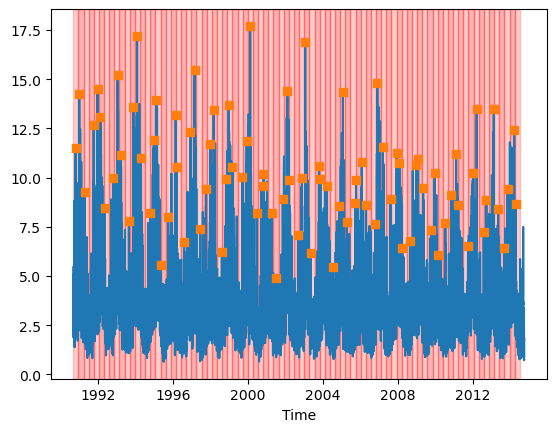

In [16]:
bm.plot_blocks()

Our goal is often to **obtain return levels for given return periods**, with confidence intervals. Here is how to do it.

<AxesSubplot:xlabel='Return period'>

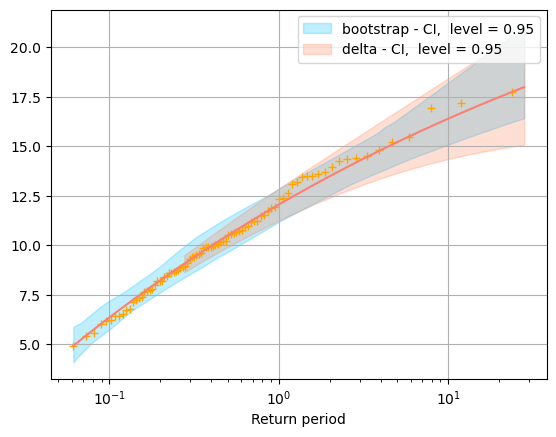

In [17]:
fig, ax = plt.subplots()
bm.plot_rp_data(ax=ax, color = "orange")
bm.plot_rp_fit(ax=ax, color = "salmon")
bm.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="bootstrap", color="deepskyblue")
bm.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="delta", color="coral")

If we want to obtain the **return level associated to a given return period**, we can calculate it **empirically** or through a **fitted** distribution.

In [18]:
print(bm.rp_to_x_empirical( 10 ))
print(bm.rp_to_x( 10 ))

17.0584083577315
16.386694376204733


It is also possible to compute the **confidence interval for a return period period** (at a given confidence level) , as well as the **relative uncertainty**.

In [19]:
CI = pot.rp_to_xci( rp = 1, ci_level=0.9 )
print(f"L'intervalle de confiance à RP = 10 et à 0.9 est [{str(CI[0])},{str(CI[1])}]")

print(f"L'intercitude relative à RP = 10 et à 0.9 est {str(pot.rp_to_rel_ci( 10 ))}") #Ici, 7.5%

L'intervalle de confiance à RP = 10 et à 0.9 est [[12.42768372],[13.46374639]]
L'intercitude relative à RP = 10 et à 0.9 est 0.07745324187764767


If we want to add xlabel on every plot, we can set object attribut "_time_label" to the label corresponding to "time unit" (*f.e, if time_unit is in years, you set time_label to "years"*)

<AxesSubplot:xlabel='Return period in years'>

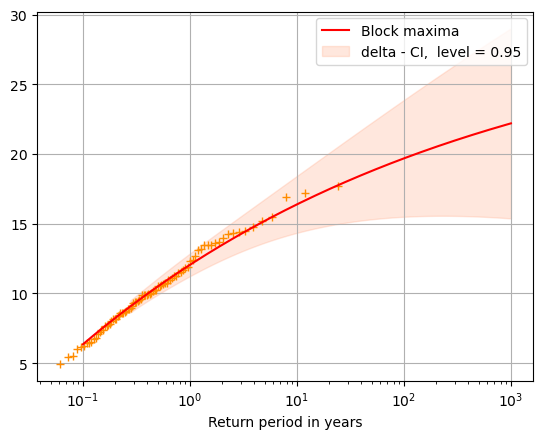

In [20]:
bm._time_label = "years"

rp_range = np.logspace(-1 ,3, 200)

fig, ax = plt.subplots()
bm.plot_rp_data(ax=ax, color = "darkorange")
bm.plot_rp_fit(ax=ax, color = "red", label = "Block maxima", rp_range = rp_range)
bm.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="delta", color="lightsalmon", rp_range = rp_range)

If we would like RP expressed in terms of days and not year, we have to build BM with 'time_convert' corresponding to days and not years : 

<AxesSubplot:xlabel='Return period in days'>

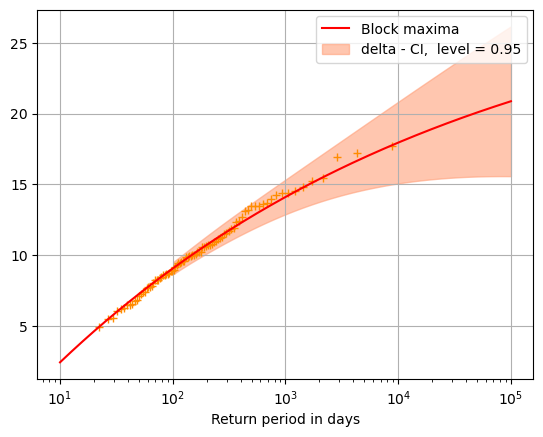

In [21]:
bm_day = st.BM_GEV.FromTimeSeries(data, block_size = timedelta(days=100) , time_convert = timedelta(days = 1) ) 
#or bm_ft_day = st.BM_GEV.FromTimeSeries( se = data_ft, block_size = 100*24/3, time_convert = 24/3 )
rp_range = np.logspace(1 ,5, 200)

bm_day._time_label = "days"
fig, ax = plt.subplots()
bm_day.plot_rp_data(ax=ax, color = "darkorange")
bm_day.plot_rp_fit(ax=ax, color = "red", label = "Block maxima", rp_range = rp_range)
bm_day.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="delta", color="lightsalmon", rp_range = rp_range, alpha = 0.6)

## Comparison of block maxima and peak over threshold

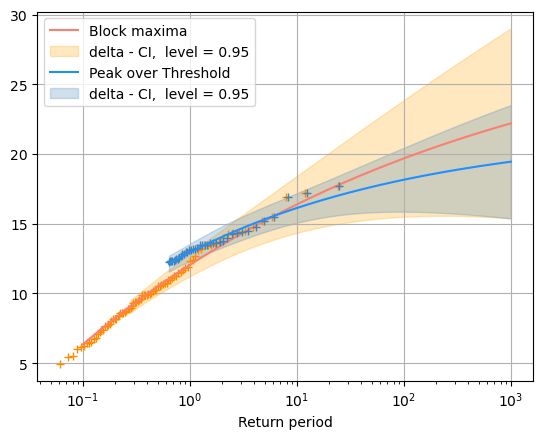

In [22]:
rp_range = np.logspace(-1 ,3, 200)

fig, ax = plt.subplots()
bm.plot_rp_data(ax=ax, color = "darkorange")
bm.plot_rp_fit(ax=ax, color = "salmon", label = "Block maxima", rp_range = rp_range)
bm.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="delta", color="orange", rp_range = rp_range)

pot.plot_rp_data(ax=ax, color = "steelblue")
pot.plot_rp_fit(ax=ax, color = "dodgerblue", label = "Peak over Threshold", rp_range = rp_range)
pot.plot_rp_ci(ax=ax, ci_level=0.95, ci_type = "delta", color = "steelblue", rp_range = rp_range)
ax.legend(loc = "upper left")


Here, we can observe a large difference in return levels at low RP, even in the plotting of sampling data. We will see that it is mainly due to data itself and the way we treat it. We are looking at 3h-maxima in Hs on a specific location for a total duration of 24 years. We are applying block-maxima, with blocks of size **100 days** and P-o-T on a signal that has been declustered with a window of **10 days**.
In fact, the signal presents a large **seasonal variation**, with higher values during winter during storm events. By applying block-maxima of size 100 days, we select only one (max 2) extreme events per winter. By applying PoT + 10 days declustering, we could extract a maximum every 10 days. Then, if 3 major storms appear during the same winter, PoT could extract 2 or 3 extremes while BM only 1. The largest value extracted will be the same, but not the others. It can largely explain the difference in results between PoT & BM RP-RL curves. By performing the same analysis on a sample drawn from a know weibull distribution, we'll show that the points gather between PoT & BM.

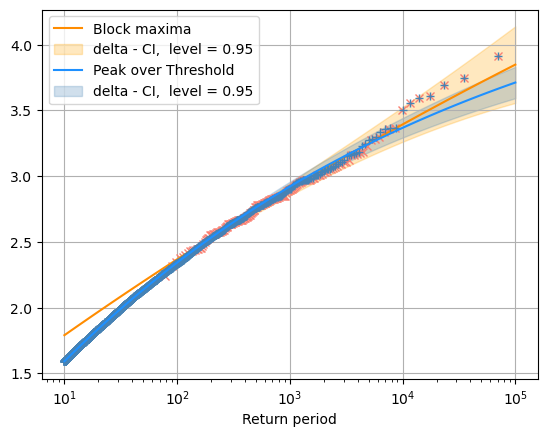

In [24]:
from scipy import stats

duration = 70000

data_dist = pd.Series((stats.weibull_min(c = 1.8)).rvs(duration))

bm = st.BM_GEV.FromTimeSeries( se = data_dist, block_size = 400 )  #80*3h = 100 jours
pot = st.POT_GPD( data_dist, duration=duration, threshold = np.quantile(data_dist, 0.90) )

rp_range = np.logspace(1, 5, 100)

fig, ax = plt.subplots()
bm.plot_rp_data(ax=ax, color = "salmon", marker = "x")
bm.plot_rp_fit(ax=ax, color = "darkorange", label = "Block maxima", rp_range = rp_range)
bm.plot_rp_ci(ax=ax, ci_level = 0.95, ci_type="delta", color="orange", rp_range = rp_range)

pot.plot_rp_data(ax=ax, color = "steelblue")
pot.plot_rp_fit(ax=ax, color = "dodgerblue", label = "Peak over Threshold", rp_range = rp_range)
pot.plot_rp_ci(ax=ax, ci_level=0.95, ci_type = "delta", color = "steelblue", rp_range = rp_range)
ax.legend(loc = "upper left")
